### Task on Transfer Learning

* Complete the session code to train for larger epochs
* Do the performnce plots and evaulation and confusion matrix
* Take A different Dataset :
    - Create A Custom Model
    - Train
    - Plot Model metrics - accuracy and loss
    - Model Evaluation
    - Apply Transfer Learning (Load Pre-trained model and Fine Tuning)

In [ ]:
# Solution - https://www.kaggle.com/code/sampsuman/transferlearning-finetuning

## Task for Session 10

* Create a Model Architecture from scratch for SQUEEZENET
    - Paper link: https://arxiv.org/pdf/1602.07360
    - https://medium.com/@avidrishik/squeezenets-architecture-compressed-neural-network-7741d24ca56f

#### Solution

Dataset : https://www.kaggle.com/datasets/anshulmehtakaggl/chess-pieces-detection-images-dataset

In [ ]:
# You need to upload kaggle.json file

In [ ]:
!mkdir -p ./kaggle
!cp kaggle.json ~/.kaggle/
# Download the dataset
!kaggle datasets download -d anshulmehtakaggl/chess-pieces-detection-images-dataset

# Unzip the dataset
!unzip chess-pieces-detection-images-dataset.zip -d chess_pieces_dataset

cp: cannot create regular file '/root/.kaggle/': Not a directory
Dataset URL: https://www.kaggle.com/datasets/anshulmehtakaggl/chess-pieces-detection-images-dataset
License(s): CC0-1.0
  0% 0.00/3.47M [00:00<?, ?B/s]
100% 3.47M/3.47M [00:00<00:00, 137MB/s]
Archive:  chess-pieces-detection-images-dataset.zip
  inflating: chess_pieces_dataset/Queen-Resized/00000000_resized.jpg  
  inflating: chess_pieces_dataset/Queen-Resized/00000001_resized.jpg  
  inflating: chess_pieces_dataset/Queen-Resized/00000003_resized.jpg  
  inflating: chess_pieces_dataset/Queen-Resized/00000004_resized.jpg  
  inflating: chess_pieces_dataset/Queen-Resized/00000005_resized.jpg  
  inflating: chess_pieces_dataset/Queen-Resized/00000007_resized.jpg  
  inflating: chess_pieces_dataset/Queen-Resized/00000008_resized.jpg  
  inflating: chess_pieces_dataset/Queen-Resized/00000010_resized.jpg  
  inflating: chess_pieces_dataset/Queen-Resized/00000011_resized.jpg  
  inflating: chess_pieces_dataset/Queen-Resized/0000

##### Data Loader

In [ ]:
import os
import shutil
import numpy as np
from sklearn.model_selection import train_test_split

# Paths
base_dir = '/content/chess_pieces_dataset'
train_dir = '/content/chess_pieces_dataset_split/train'
val_dir = '/content/chess_pieces_dataset_split/validation'
test_dir = '/content/chess_pieces_dataset_split/test'

# Create directories for splits
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Create subdirectories for each class in the split directories
for class_name in os.listdir(base_dir):
    class_path = os.path.join(base_dir, class_name)
    if os.path.isdir(class_path):
        os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
        os.makedirs(os.path.join(val_dir, class_name), exist_ok=True)
        os.makedirs(os.path.join(test_dir, class_name), exist_ok=True)

        # Get all image files in the class directory
        images = [f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))]

        # Split the data
        train_imgs, test_imgs = train_test_split(images, test_size=0.25, random_state=42)
        val_imgs, test_imgs = train_test_split(test_imgs, test_size=0.60, random_state=42)

        # Copy files to respective directories
        for img in train_imgs:
            shutil.copy(os.path.join(class_path, img), os.path.join(train_dir, class_name, img))

        for img in val_imgs:
            shutil.copy(os.path.join(class_path, img), os.path.join(val_dir, class_name, img))

        for img in test_imgs:
            shutil.copy(os.path.join(class_path, img), os.path.join(test_dir, class_name, img))

print("Data splitting completed.")


Data splitting completed.


#### Model Architecture - SqueezeNet

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Fire module definition
def fire_module(x, squeeze_filters, expand_1x1_filters, expand_3x3_filters, name):
    # Squeeze layer: 1x1 convolution
    squeeze = layers.Conv2D(squeeze_filters, (1, 1), padding='same', activation='relu', name=name + '_squeeze')(x)

    # Expand layer: 1x1 convolution
    expand_1x1 = layers.Conv2D(expand_1x1_filters, (1, 1), padding='same', activation='relu', name=name + '_expand_1x1')(squeeze)

    # Expand layer: 3x3 convolution
    expand_3x3 = layers.Conv2D(expand_3x3_filters, (3, 3), padding='same', activation='relu', name=name + '_expand_3x3')(squeeze)

    # Concatenate the outputs of the expand layers
    output = layers.concatenate([expand_1x1, expand_3x3], axis=-1, name=name + '_concat')

    return output


In [ ]:
# Full SqueezeNet model
def SqueezeNet(input_shape=(224, 224, 3), num_classes=1000):
    input_layer = layers.Input(shape=input_shape)

    # Initial Conv Layer
    x = layers.Conv2D(96, (7, 7), strides=(2, 2), padding='same', activation='relu', name='conv1')(input_layer)
    x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same', name='maxpool1')(x)

    # Fire Modules
    x = fire_module(x, 16, 64, 64, name='fire2')
    x = fire_module(x, 16, 64, 64, name='fire3')
    x = fire_module(x, 32, 128, 128, name='fire4')

    # Max Pooling after fire4
    x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same', name='maxpool4')(x)

    x = fire_module(x, 32, 128, 128, name='fire5')
    x = fire_module(x, 48, 192, 192, name='fire6')
    x = fire_module(x, 48, 192, 192, name='fire7')

    # Max Pooling after fire7
    x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same', name='maxpool7')(x)

    x = fire_module(x, 64, 256, 256, name='fire8')
    x = fire_module(x, 64, 256, 256, name='fire9')

    # Dropout layer for regularization
    x = layers.Dropout(0.5, name='dropout')(x)

    # Final Conv Layer before classification
    x = layers.Conv2D(num_classes, (1, 1), padding='valid', activation='relu', name='conv10')(x)

    # Global Average Pooling to reduce dimensions
    x = layers.GlobalAveragePooling2D(name='global_avgpool10')(x)

    # Softmax activation for classification
    output_layer = layers.Activation('softmax', name='softmax')(x)

    # Define the model
    model = models.Model(inputs=input_layer, outputs=output_layer)

    return model

# Instantiate the SqueezeNet model
model = SqueezeNet(input_shape=(224, 224, 3), num_classes=1000)

# Print model summary
model.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1 (Conv2D)            │ (None, 112, 112, 96)   │         14,208 │ input_layer_6[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ maxpool1 (MaxPooling2D)   │ (None, 56, 56, 96)     │              0 │ conv1[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ fire2_squeeze (Conv2D)    │ (None, 56, 56, 16)     │          1,552 │ maxpool1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ fire2_expand_1x1 (Conv2D) │ (None, 56, 56, 64)     │          1,088 │ fire2_squeeze[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ fire2_expand_3x3 (Conv2D) │ (None, 56, 56, 64)     │          9,280 │ fire2_squeeze[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ fire2_concat              │ (None, 56, 56, 128)    │              0 │ fire2_expand_1x1[0][0… │
│ (Concatenate)             │                        │                │ fire2_expand_3x3[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ fire3_squeeze (Conv2D)    │ (None, 56, 56, 16)     │          2,064 │ fire2_concat[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ fire3_expand_1x1 (Conv2D) │ (None, 56, 56, 64)     │          1,088 │ fire3_squeeze[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ fire3_expand_3x3 (Conv2D) │ (None, 56, 56, 64)     │          9,280 │ fire3_squeeze[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ fire3_concat              │ (None, 56, 56, 128)    │              0 │ fire3_expand_1x1[0][0… │
│ (Concatenate)             │                        │                │ fire3_expand_3x3[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ fire4_squeeze (Conv2D)    │ (None, 56, 56, 32)     │          4,128 │ fire3_concat[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ fire4_expand_1x1 (Conv2D) │ (None, 56, 56, 128)    │          4,224 │ fire4_squeeze[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ fire4_expand_3x3 (Conv2D) │ (None, 56, 56, 128)    │         36,992 │ fire4_squeeze[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ fire4_concat              │ (None, 56, 56, 256)    │              0 │ fire4_expand_1x1[0][0… │
│ (Concatenate)             │                        │                │ fire4_expand_3x3[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ maxpool4 (MaxPooling2D)   │ (None, 28, 28, 256)    │              0 │ fire4_concat[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ fire5_squeeze (Conv2D)    │ (None, 28, 28, 32)     │          8,224 │ maxpool4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ fire5_expand_1x1 (Con

 Total params: 1,248,424 (4.76 MB)

 Trainable params: 1,248,424 (4.76 MB)

 Non-trainable params: 0 (0.00 B)

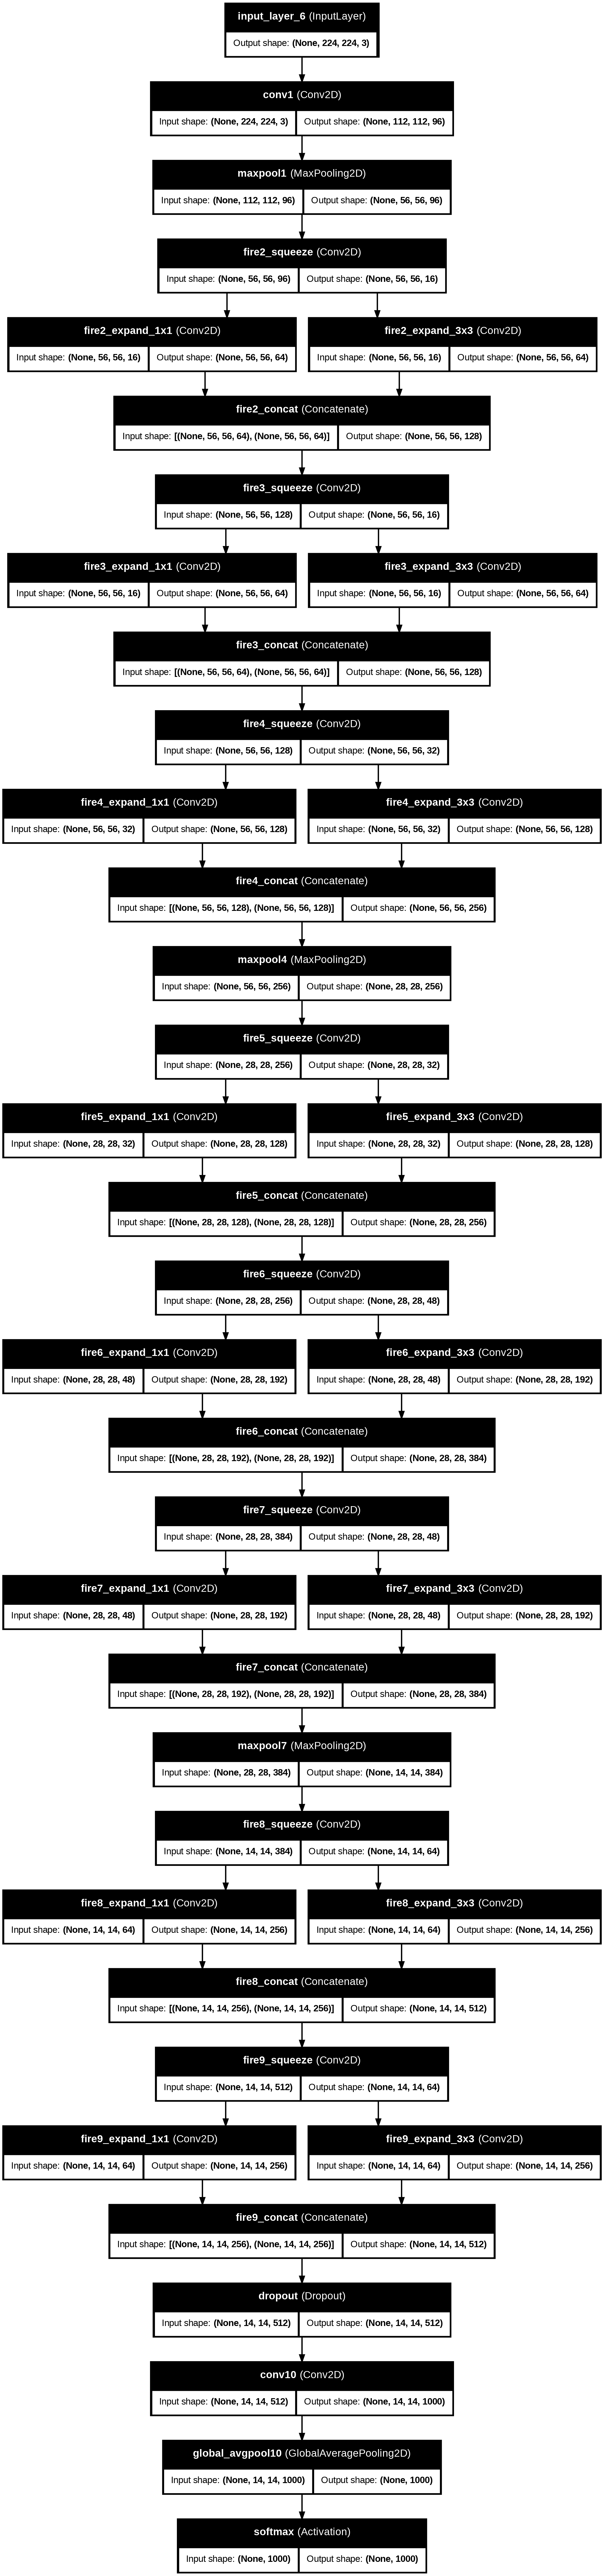

In [ ]:
# Plot the model architecture
plot_model(model, to_file='squeezenet_original_model.png', show_shapes=True, show_layer_names=True)

#### Training on a dataset with 5 classes:

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models


# Define image size and batch size
image_size = (224, 224)
batch_size = 16


# Create an ImageDataGenerator for training (with augmentation)
train_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    fill_mode='constant',
    cval=0
)

# For validation and test data, only rescale (no augmentation)
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Load data using ImageDataGenerator
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    seed=42
)

val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False,
    seed=42
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False,
    seed=42
)

Found 486 images belonging to 5 classes.
Found 64 images belonging to 5 classes.
Found 101 images belonging to 5 classes.


In [ ]:
# SqueezeNet Model with Random Initialization
def fire_module(x, squeeze_filters, expand_1x1_filters, expand_3x3_filters, name):
    squeeze = layers.Conv2D(squeeze_filters, (1, 1), padding='same', activation='relu', name=name + '_squeeze')(x)
    expand_1x1 = layers.Conv2D(expand_1x1_filters, (1, 1), padding='same', activation='relu', name=name + '_expand_1x1')(squeeze)
    expand_3x3 = layers.Conv2D(expand_3x3_filters, (3, 3), padding='same', activation='relu', name=name + '_expand_3x3')(squeeze)
    output = layers.concatenate([expand_1x1, expand_3x3], axis=-1, name=name + '_concat')
    return output

def SqueezeNet(input_shape=(256, 256, 3), num_classes=5):
    input_layer = layers.Input(shape=input_shape)

    # Initial Conv Layer
    x = layers.Conv2D(96, (7, 7), strides=(2, 2), padding='same', activation='relu', name='conv1')(input_layer)
    x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same', name='maxpool1')(x)

    # Fire Modules
    x = fire_module(x, 16, 64, 64, name='fire2')
    x = fire_module(x, 16, 64, 64, name='fire3')
    x = fire_module(x, 32, 128, 128, name='fire4')

    # Max Pooling after fire4
    x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same', name='maxpool4')(x)

    x = fire_module(x, 32, 128, 128, name='fire5')
    x = fire_module(x, 48, 192, 192, name='fire6')
    x = fire_module(x, 48, 192, 192, name='fire7')

    # Max Pooling after fire7
    x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same', name='maxpool7')(x)

    x = fire_module(x, 64, 256, 256, name='fire8')
    x = fire_module(x, 64, 256, 256, name='fire9')

    # Dropout layer for regularization
    x = layers.Dropout(0.5, name='dropout')(x)

    # Final Conv Layer before classification
    x = layers.Conv2D(num_classes, (1, 1), padding='valid', activation='relu', name='conv10')(x)

    # Global Average Pooling to reduce dimensions
    x = layers.GlobalAveragePooling2D(name='global_avgpool10')(x)

    # Softmax activation for classification
    output_layer = layers.Activation('softmax', name='softmax')(x)

    # Define the model
    model = models.Model(inputs=input_layer, outputs=output_layer)

    return model

# Initialize the model
model = SqueezeNet(input_shape=(224, 224, 3), num_classes=5)

In [ ]:
model.summary()

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1 (Conv2D)            │ (None, 112, 112, 96)   │         14,208 │ input_layer_9[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ maxpool1 (MaxPooling2D)   │ (None, 56, 56, 96)     │              0 │ conv1[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ fire2_squeeze (Conv2D)    │ (None, 56, 56, 16)     │          1,552 │ maxpool1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ fire2_expand_1x1 (Conv2D) │ (None, 56, 56, 64)     │          1,088 │ fire2_squeeze[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ fire2_expand_3x3 (Conv2D) │ (None, 56, 56, 64)     │          9,280 │ fire2_squeeze[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ fire2_concat              │ (None, 56, 56, 128)    │              0 │ fire2_expand_1x1[0][0… │
│ (Concatenate)             │                        │                │ fire2_expand_3x3[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ fire3_squeeze (Conv2D)    │ (None, 56, 56, 16)     │          2,064 │ fire2_concat[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ fire3_expand_1x1 (Conv2D) │ (None, 56, 56, 64)     │          1,088 │ fire3_squeeze[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ fire3_expand_3x3 (Conv2D) │ (None, 56, 56, 64)     │          9,280 │ fire3_squeeze[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ fire3_concat              │ (None, 56, 56, 128)    │              0 │ fire3_expand_1x1[0][0… │
│ (Concatenate)             │                        │                │ fire3_expand_3x3[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ fire4_squeeze (Conv2D)    │ (None, 56, 56, 32)     │          4,128 │ fire3_concat[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ fire4_expand_1x1 (Conv2D) │ (None, 56, 56, 128)    │          4,224 │ fire4_squeeze[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ fire4_expand_3x3 (Conv2D) │ (None, 56, 56, 128)    │         36,992 │ fire4_squeeze[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ fire4_concat              │ (None, 56, 56, 256)    │              0 │ fire4_expand_1x1[0][0… │
│ (Concatenate)             │                        │                │ fire4_expand_3x3[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ maxpool4 (MaxPooling2D)   │ (None, 28, 28, 256)    │              0 │ fire4_concat[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ fire5_squeeze (Conv2D)    │ (None, 28, 28, 32)     │          8,224 │ maxpool4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ fire5_expand_1x1 (Con

 Total params: 737,989 (2.82 MB)

 Trainable params: 737,989 (2.82 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
train_generator.reset()
val_generator.reset()

# Train the model for 2 epochs
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=2
)

Epoch 1/2
31/31 ━━━━━━━━━━━━━━━━━━━━ 133s 3s/step - accuracy: 0.2695 - loss: 1.5874 - val_accuracy: 0.2656 - val_loss: 1.5834
Epoch 2/2
31/31 ━━━━━━━━━━━━━━━━━━━━ 81s 3s/step - accuracy: 0.2819 - loss: 1.5702 - val_accuracy: 0.2656 - val_loss: 1.5843


In [ ]:
# Evaluate on the test set
test_loss, test_acc = model.evaluate(test_generator, steps=test_generator.samples // batch_size)
print(f"Test Accuracy: {test_acc:.4f}")

6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 717ms/step - accuracy: 0.1210 - loss: 1.6115
Test Accuracy: 0.2812


--